# MSCA 31009 Machine Learning & Predictive Analytics
## Final Project - Deep Learning Based Steam Store Game Recommender System
### Exploratory Data Analysis and Feature Engineering
Shijia Huang

-----

In [1]:
# Import basic libraries
import sys
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model

import re
import nltk
from nltk.corpus import stopwords

2023-05-22 13:36:01.039082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [4]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


### Games

In [5]:
# read in the preprocessed data
games_df = pd.read_csv('preprocessed/games.csv')
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48756 entries, 0 to 48755
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          48756 non-null  int64  
 1   title           48756 non-null  object 
 2   date_release    48756 non-null  object 
 3   win             48756 non-null  int64  
 4   mac             48756 non-null  int64  
 5   linux           48756 non-null  int64  
 6   rating          48756 non-null  int64  
 7   positive_ratio  48756 non-null  int64  
 8   user_reviews    48756 non-null  int64  
 9   price_final     48756 non-null  float64
 10  price_original  48756 non-null  float64
 11  discount        48756 non-null  float64
dtypes: float64(3), int64(7), object(2)
memory usage: 4.5+ MB


In [6]:
games_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount
0,10090,Call of Duty: World at War,2008-11-18,1,0,0,3,92,37039,19.99,19.99,0.0
1,13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,3,84,2199,9.99,9.99,0.0
2,22364,BRINK: Agents of Change,2011-08-03,1,0,0,2,85,21,2.99,2.99,0.0
3,113020,Monaco: What's Yours Is Mine,2013-04-24,1,1,1,3,92,3722,14.99,14.99,0.0
4,226560,Escape Dead Island,2014-11-18,1,0,0,0,61,873,14.99,14.99,0.0


In [7]:
# phrasing the date column
games_df['date_release'] = pd.to_datetime(games_df['date_release'], format='%Y-%m-%d')

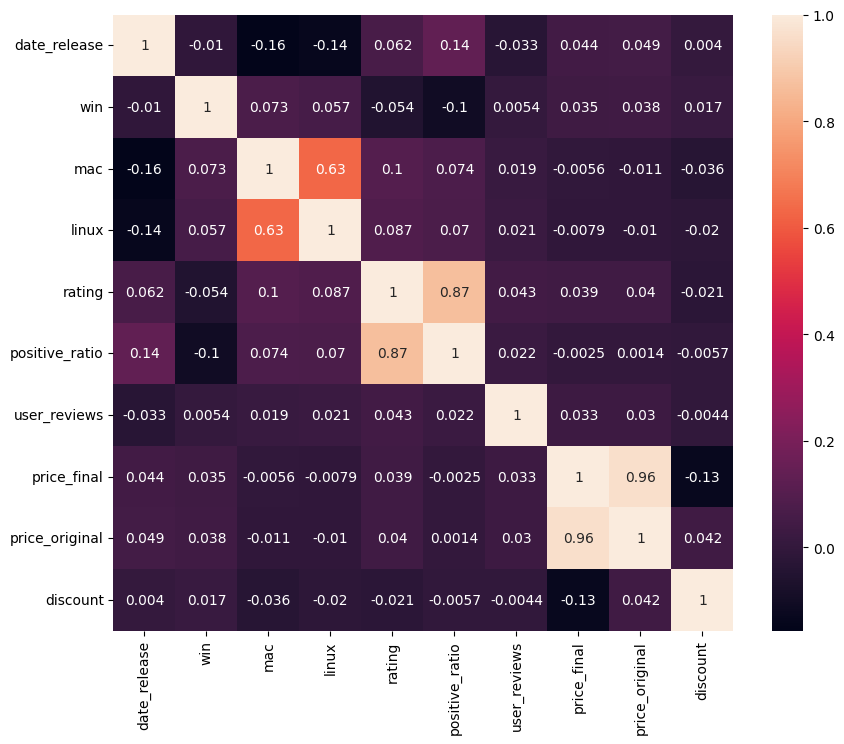

In [8]:
# plot correlation between numerical columns
plt.figure(figsize=(10, 8))
cols = ['date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount']
sns.heatmap(games_df[cols].corr(), annot=True)
plt.show()

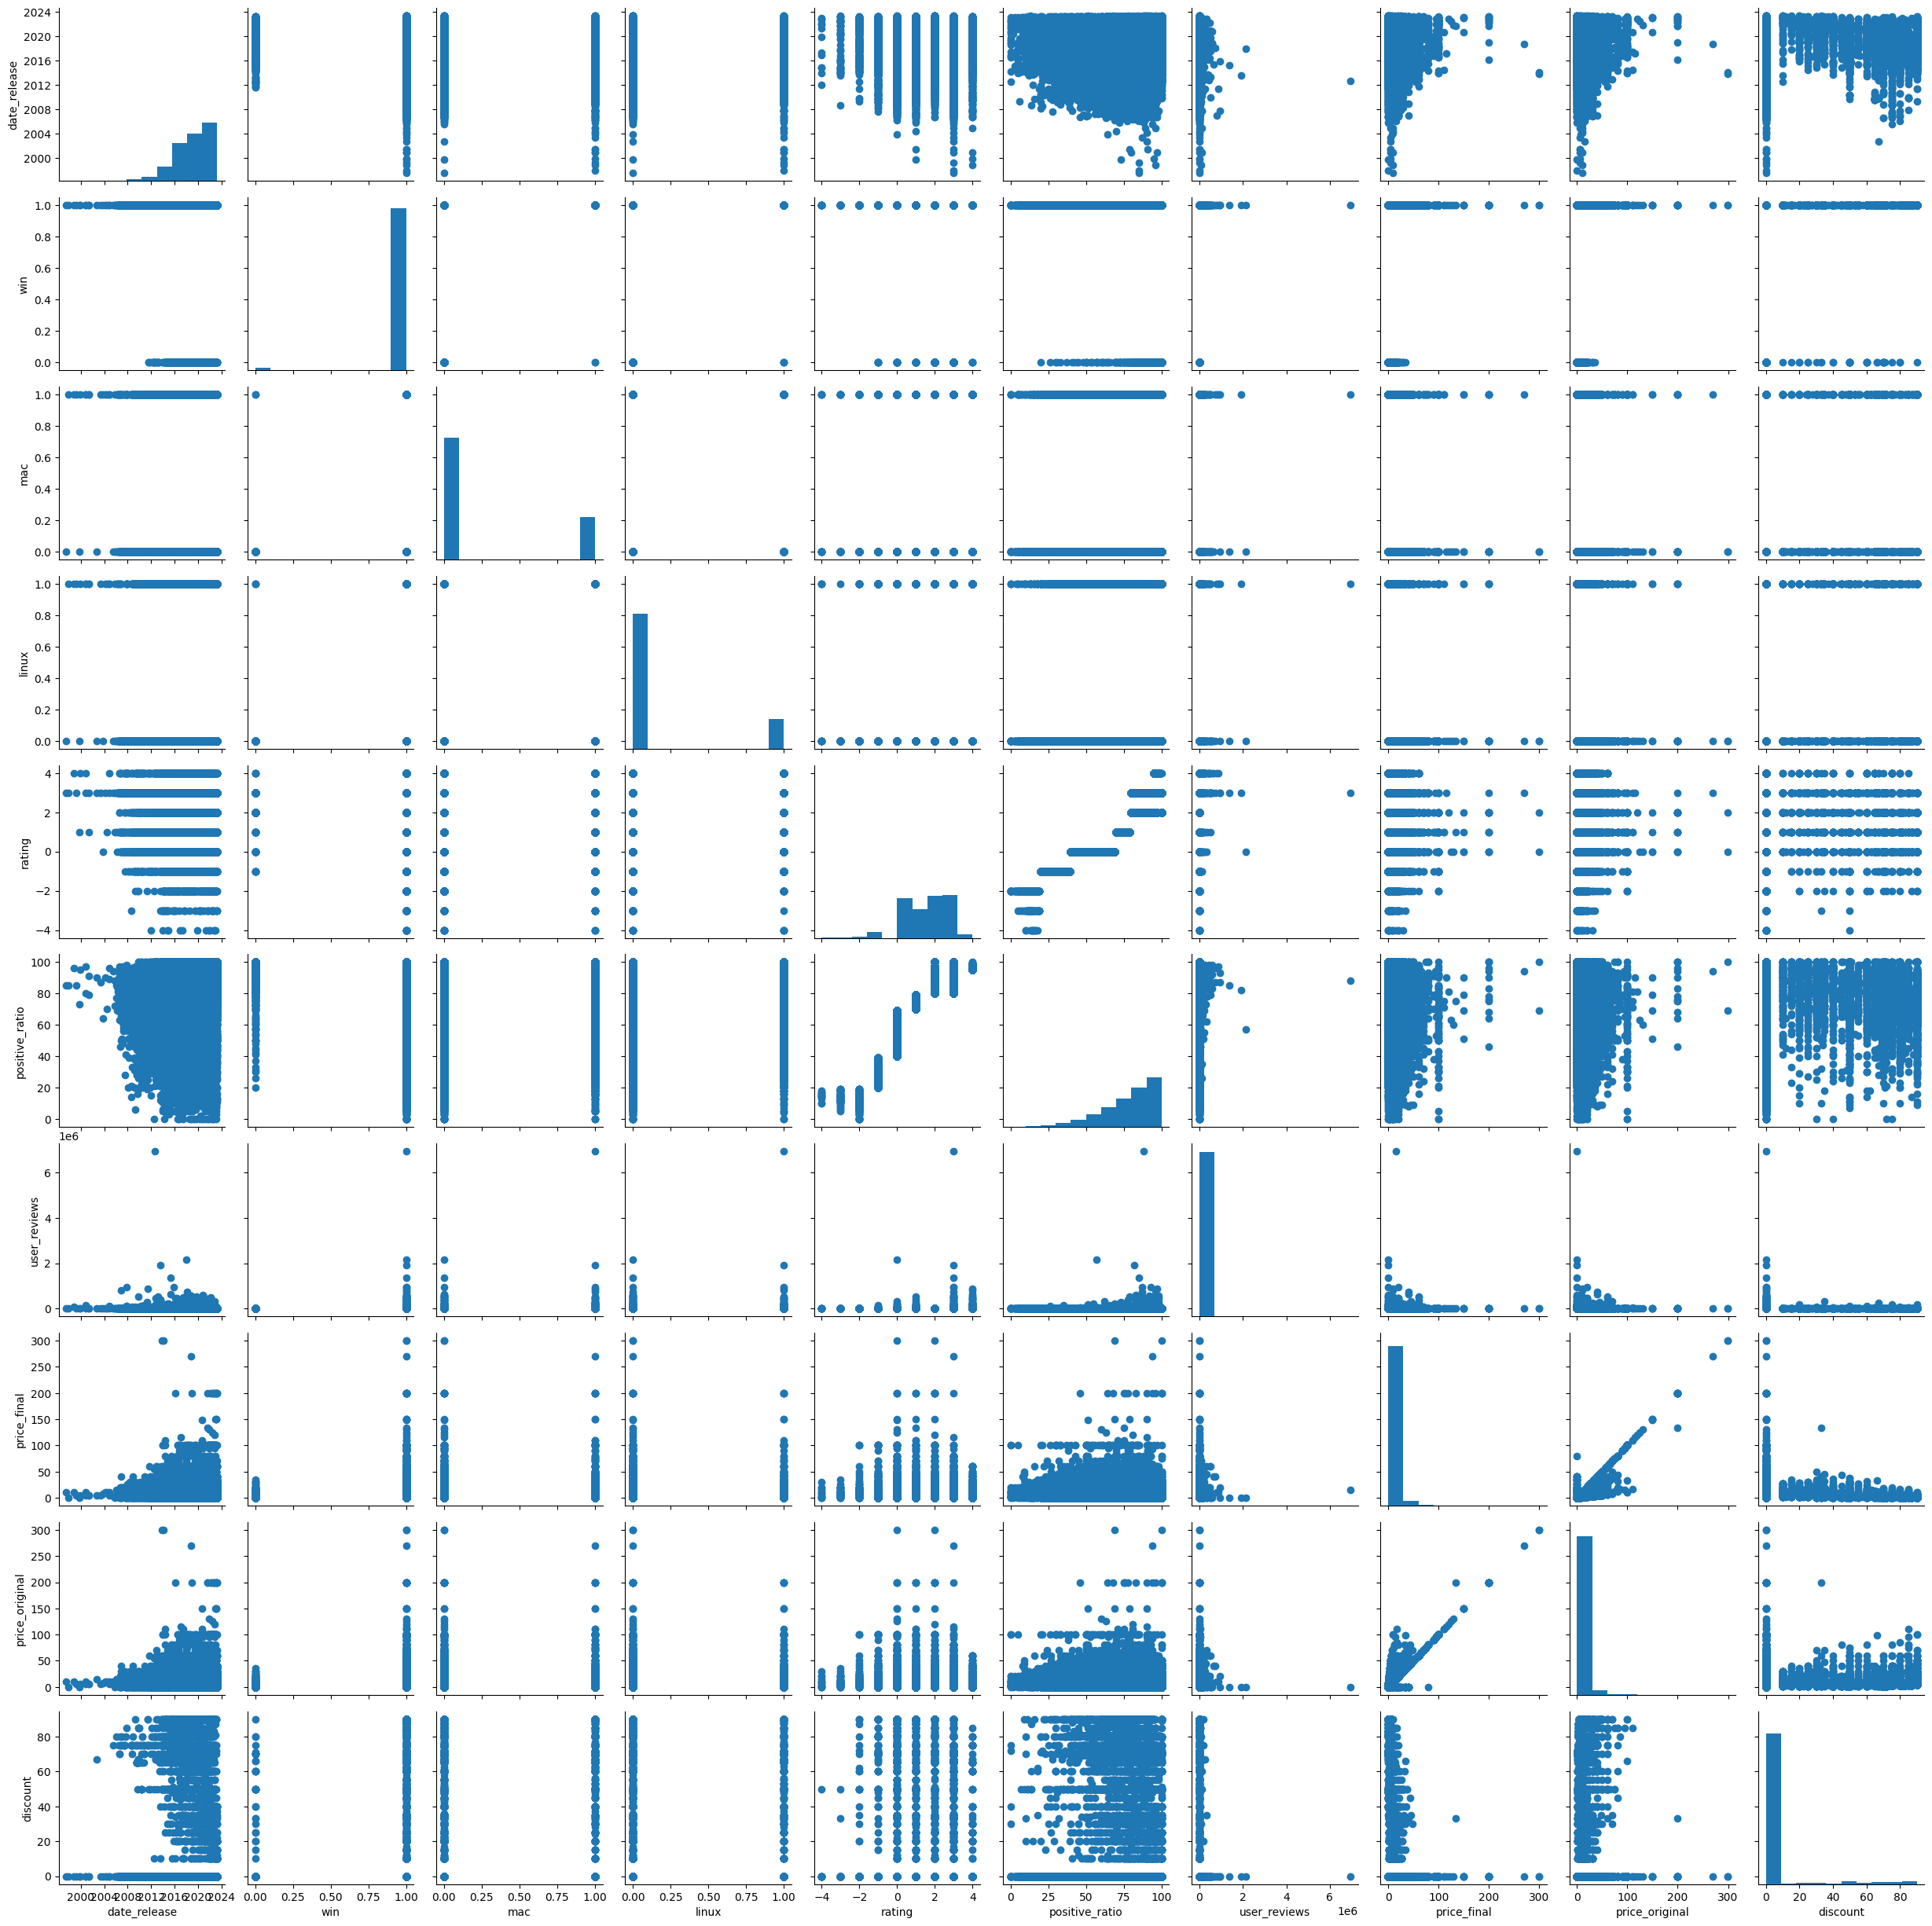

In [9]:
# make pairplot for numerical columns where diagonal is a histogram and other plots are scatter plots

ax = sns.PairGrid(games_df[cols], vars=cols)
ax = ax.map_offdiag(plt.scatter)
ax = ax.map_diag(plt.hist)

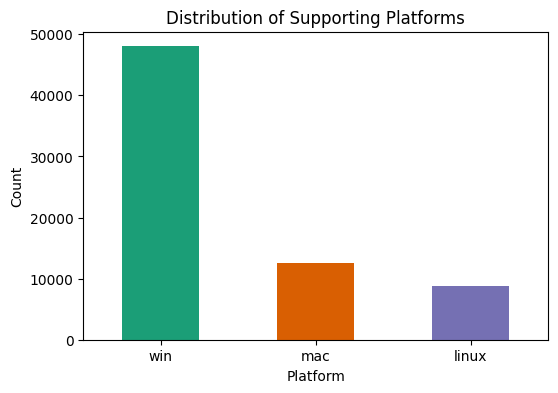

In [10]:
# plot supporting platforms: win, mac, linux using bar plot

# Calculate the count of each platform combination
subset_df = games_df[['win', 'mac', 'linux']]
platform_counts = subset_df.sum()

# Plot the bar plot
plt.figure(figsize=(6, 4))
platform_counts.plot(kind='bar', stacked=True, color=['#1b9e77', '#d95f02', '#7570b3'])
plt.title('Distribution of Supporting Platforms')
plt.xlabel('Platform')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()


In [69]:
platform_counts

# rename the index
platform_counts.index = ['Windows', 'Mac', 'Linux']

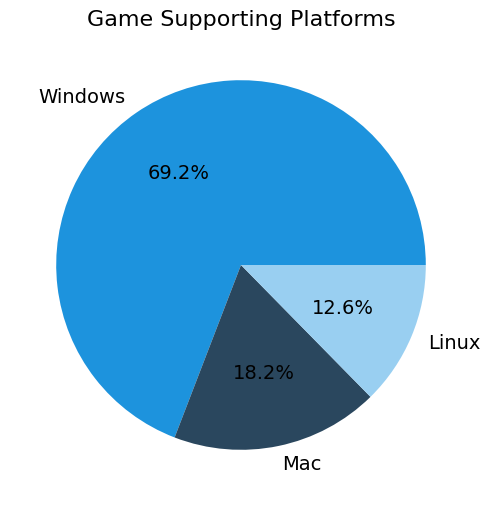

In [71]:
# plot a pie chart for supporting platforms
plt.figure(figsize=(6, 6))
pie = platform_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#1D93DD', '#2A475E', '#99cff1'], fontsize=14)
plt.title('Game Supporting Platforms', fontsize=16)
plt.ylabel('')
plt.show()

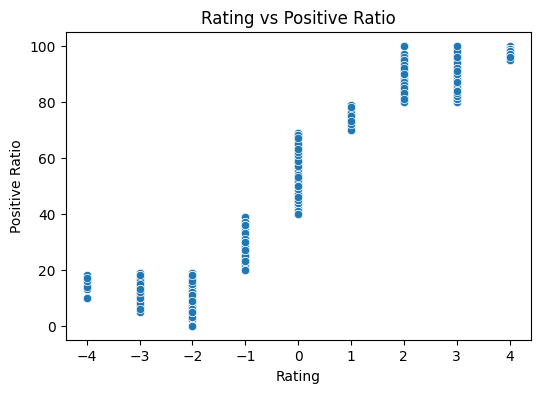

In [11]:
# rating vs positive_ratio
plt.figure(figsize=(6, 4))
sns.scatterplot(data=games_df, x='rating', y='positive_ratio')
plt.title('Rating vs Positive Ratio')
plt.xlabel('Rating')
plt.ylabel('Positive Ratio')
plt.show()

In [89]:
ratings = games_df['rating'].value_counts().sort_index()
ratings

rating
-4       13
-3       56
-2      290
-1     1794
 0    11808
 1     8449
 2    12564
 3    12715
 4     1067
Name: count, dtype: int64

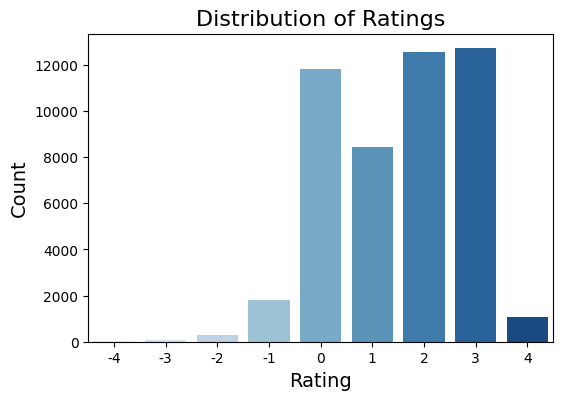

In [90]:
# plot a bar plot for ratings using seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x=ratings.index, y=ratings.values, palette='Blues')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [110]:
# group by year-month of release date and rating and count the number of games
games_df['year_month'] = games_df['date_release'].dt.strftime('%Y-%m')
games_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,year_month
0,10090,Call of Duty: World at War,2008-11-18,1,0,0,3,92,37039,19.99,19.99,0.0,2008-11
1,13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,3,84,2199,9.99,9.99,0.0,2008-11
2,22364,BRINK: Agents of Change,2011-08-03,1,0,0,2,85,21,2.99,2.99,0.0,2011-08
3,113020,Monaco: What's Yours Is Mine,2013-04-24,1,1,1,3,92,3722,14.99,14.99,0.0,2013-04
4,226560,Escape Dead Island,2014-11-18,1,0,0,0,61,873,14.99,14.99,0.0,2014-11


In [113]:
# group by year-month of release date and rating and count the number of games
rating_counts = games_df.groupby(['year_month', 'rating']).size().reset_index(name='count')

rating_counts.head()

,year_month,rating,count
0,1997-06,3,1
1,1997-11,3,1
2,1998-11,4,1
3,1999-04,3,1
4,1999-09,1,1


In [117]:
rating_counts.dtypes

year_month    object
rating         int64
count          int64
dtype: object

In [115]:
rating_counts['rating'].unique()

array([ 3,  4,  1,  0,  2, -1, -3, -2, -4])

In [118]:
# phrase the year_month column
rating_counts['year_month'] = pd.to_datetime(rating_counts['year_month'], format='%Y-%m')
rating_counts.dtypes

year_month    datetime64[ns]
rating                 int64
count                  int64
dtype: object

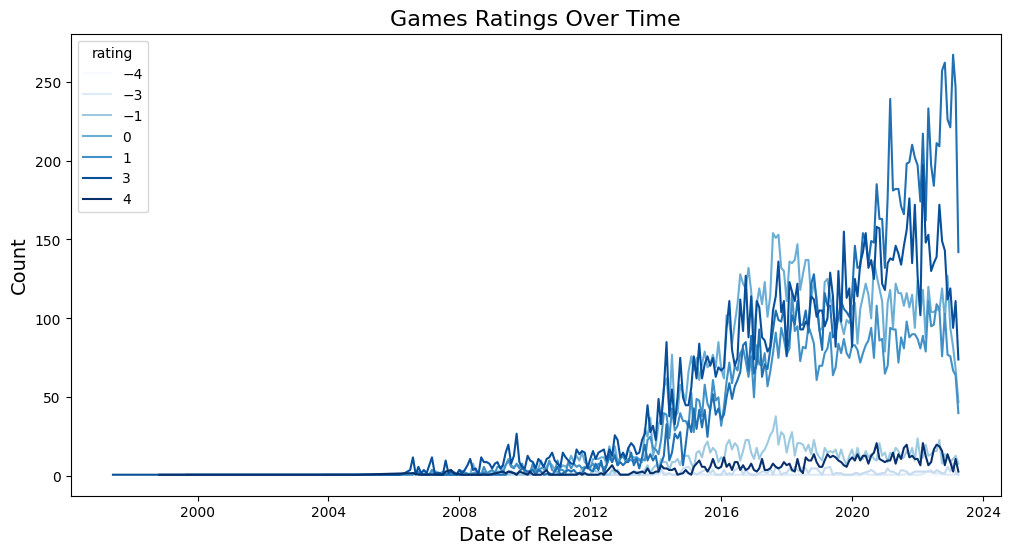

In [120]:
# plot a line plot for rating counts
plt.figure(figsize=(12, 6))
sns.lineplot(data=rating_counts, x='year_month', y='count', hue='rating', palette='Blues')
plt.title('Games Ratings Over Time', fontsize=16)
plt.xlabel('Date of Release', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

### Game Details

In [12]:
# read in the preprocessed data
games_detail_df = pd.read_csv('preprocessed/games_detail.csv')
games_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39677 entries, 0 to 39676
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          39677 non-null  int64  
 1   title           39677 non-null  object 
 2   date_release    39677 non-null  object 
 3   win             39677 non-null  int64  
 4   mac             39677 non-null  int64  
 5   linux           39677 non-null  int64  
 6   rating          39677 non-null  int64  
 7   positive_ratio  39677 non-null  int64  
 8   user_reviews    39677 non-null  int64  
 9   price_final     39677 non-null  float64
 10  price_original  39677 non-null  float64
 11  discount        39677 non-null  float64
 12  description     39677 non-null  object 
 13  tags            39677 non-null  object 
dtypes: float64(3), int64(7), object(4)
memory usage: 4.2+ MB


In [13]:
games_detail_df.head(2)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,description,tags
0,10090,Call of Duty: World at War,2008-11-18,1,0,0,3,92,37039,19.99,19.99,0.0,"Call of Duty is back, redefining war like you've never experienced before. Building on the Call of Duty 4®: Modern Warfare engine, Call of Duty: World at War immerses players into the most gritty and chaotic WWII combat ever experienced.","['Zombies', 'World War II', 'FPS', 'Multiplayer', 'Action', 'Shooter', 'Co-op', 'Singleplayer', 'Moddable', 'First-Person', 'War', 'Online Co-Op', 'Gore', 'Historical', 'Classic', 'Survival', 'Great Soundtrack', 'Tanks', 'Horror', 'Adventure']"
1,13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,3,84,2199,9.99,9.99,0.0,"Enter the dark underworld of Prince of Persia Warrior Within, the sword-slashing sequel to the critically acclaimed Prince of Persia: The Sands of Time™. Hunted by Dahaka, an immortal incarnation of Fate seeking divine retribution, the Prince embarks upon a path of both carnage and mystery to defy his preordained death.","['Action', 'Adventure', 'Parkour', 'Third Person', 'Great Soundtrack', 'Singleplayer', 'Platformer', 'Time Travel', 'Atmospheric', 'Classic', 'Hack and Slash', 'Time Manipulation', 'Gore', 'Fantasy', 'Story Rich', 'Dark', 'Open World', 'Controller', 'Dark Fantasy', 'Puzzle']"


In [14]:
# get unqiue list of tags from the tags column (list of tags)
tags = set()
for tag_list in games_detail_df['tags']:
    for tag in eval(tag_list):
        tags.add(tag)

tags = list(tags)
tags[:10]

['Offroad',
 'Science',
 'Outbreak Sim',
 'Indie',
 'Detective',
 'Interactive Fiction',
 'Well-Written',
 'Sequel',
 'Photo Editing',
 'Souls-like']

In [15]:
len(tags)

441

In [16]:
# count the number of tags appeared in each game
from collections import Counter

tags_counter = Counter()

for tag_list in games_detail_df['tags']:
    tags_counter.update(eval(tag_list))

tags_counter.most_common(10)

[('Indie', 24566),
 ('Singleplayer', 21291),
 ('Adventure', 17462),
 ('Action', 17438),
 ('Casual', 16154),
 ('2D', 10863),
 ('Simulation', 9309),
 ('Strategy', 8922),
 ('Atmospheric', 8180),
 ('RPG', 8175)]

In [17]:
# select tags that appeared more than 10% of the time
tags_to_keep = [tag for tag, count in tags_counter.items() if count >= 0.1 * len(games_detail_df)]
len(tags_to_keep)

29

In [18]:
tags_to_keep

['Multiplayer',
 'Action',
 'Shooter',
 'Singleplayer',
 'First-Person',
 'Horror',
 'Adventure',
 'Atmospheric',
 'Fantasy',
 'Story Rich',
 'Puzzle',
 'Indie',
 'Strategy',
 'Casual',
 'Pixel Graphics',
 '2D',
 'Anime',
 'RPG',
 'Arcade',
 'Retro',
 'Female Protagonist',
 'Simulation',
 'Early Access',
 'Cute',
 'Funny',
 'Exploration',
 'Free to Play',
 'Colorful',
 '3D']

In [19]:
# encode tags_to_keep as binary columns in games_detail_df
for tag in tags_to_keep:
    games_detail_df[tag] = games_detail_df['tags'].apply(lambda x: 1 if tag in x else 0)

In [20]:
games_detail_df.head(2)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,description,tags,Multiplayer,Action,Shooter,Singleplayer,First-Person,Horror,Adventure,Atmospheric,Fantasy,Story Rich,Puzzle,Indie,Strategy,Casual,Pixel Graphics,2D,Anime,RPG,Arcade,Retro,Female Protagonist,Simulation,Early Access,Cute,Funny,Exploration,Free to Play,Colorful,3D
0,10090,Call of Duty: World at War,2008-11-18,1,0,0,3,92,37039,19.99,19.99,0.0,"Call of Duty is back, redefining war like you've never experienced before. Building on the Call of Duty 4®: Modern Warfare engine, Call of Duty: World at War immerses players into the most gritty and chaotic WWII combat ever experienced.","['Zombies', 'World War II', 'FPS', 'Multiplayer', 'Action', 'Shooter', 'Co-op', 'Singleplayer', 'Moddable', 'First-Person', 'War', 'Online Co-Op', 'Gore', 'Historical', 'Classic', 'Survival', 'Great Soundtrack', 'Tanks', 'Horror', 'Adventure']",1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,3,84,2199,9.99,9.99,0.0,"Enter the dark underworld of Prince of Persia Warrior Within, the sword-slashing sequel to the critically acclaimed Prince of Persia: The Sands of Time™. Hunted by Dahaka, an immortal incarnation of Fate seeking divine retribution, the Prince embarks upon a path of both carnage and mystery to defy his preordained death.","['Action', 'Adventure', 'Parkour', 'Third Person', 'Great Soundtrack', 'Singleplayer', 'Platformer', 'Time Travel', 'Atmospheric', 'Classic', 'Hack and Slash', 'Time Manipulation', 'Gore', 'Fantasy', 'Story Rich', 'Dark', 'Open World', 'Controller', 'Dark Fantasy', 'Puzzle']",0,1,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


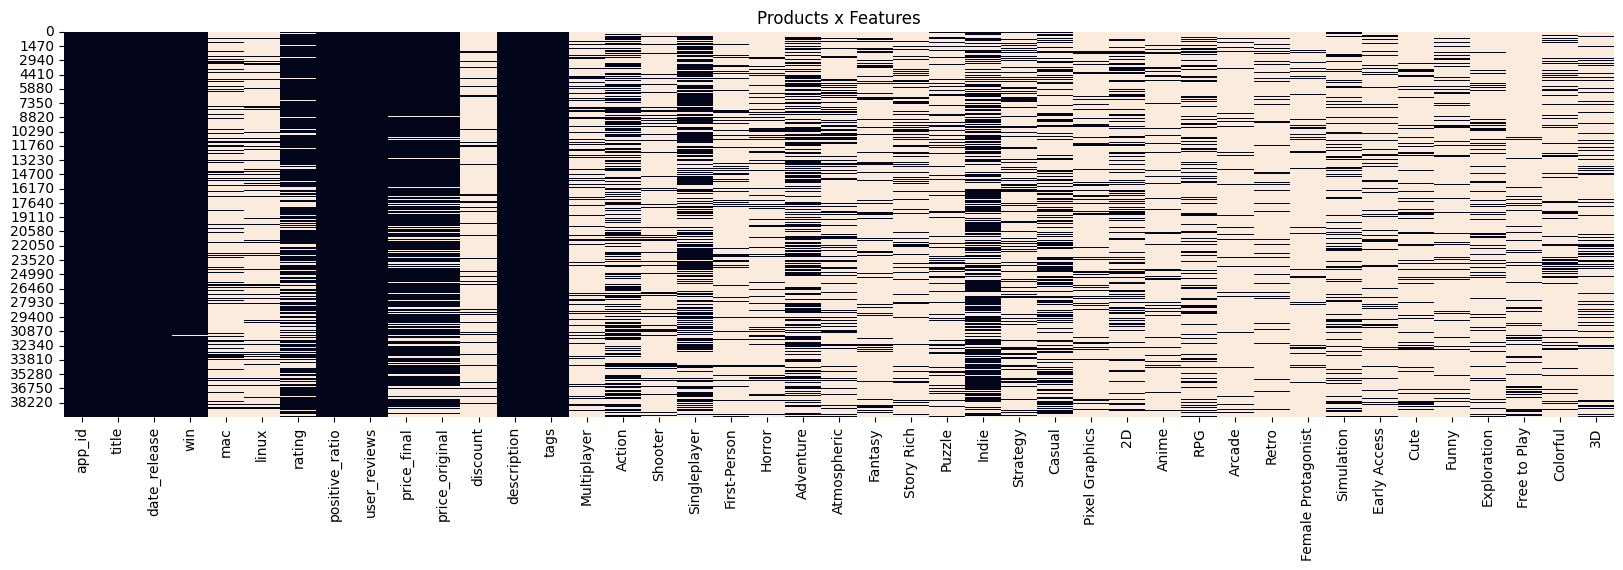

In [21]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(games_detail_df==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

In [22]:
# save the feature engineered data
games_detail_df.to_csv('feat/games_detail.csv', index=False)

### Users

In [23]:
# read in the preprocessed data
users_df = pd.read_csv('preprocessed/users.csv')
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791175 entries, 0 to 6791174
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 155.4 MB


In [24]:
users_df.head()

,user_id,products,reviews
0,6654146,156,1
1,4191643,329,4
2,2261155,176,2
3,2437528,98,2
4,2700117,144,3


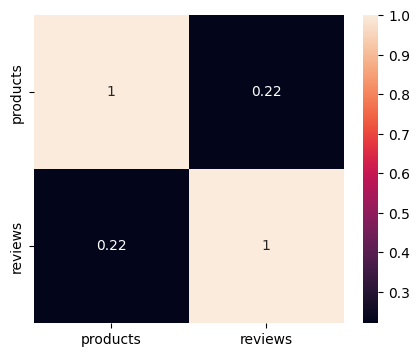

In [25]:
# plot correlation between numerical columns
plt.figure(figsize=(5, 4))
cols = ['products', 'reviews']
sns.heatmap(users_df[cols].corr(), annot=True)
plt.show()

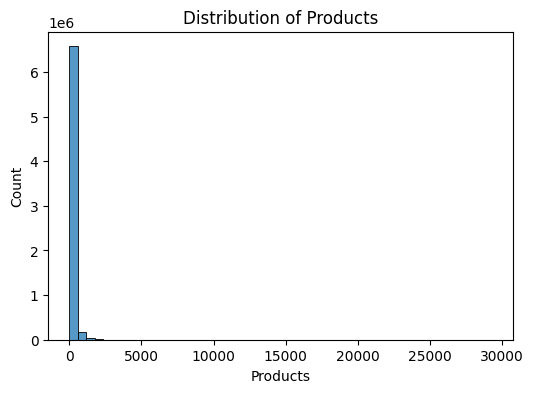

In [26]:
# plot distribution of products
plt.figure(figsize=(6, 4))
sns.histplot(data=users_df, x='products', bins=50)
plt.title('Distribution of Products')
plt.xlabel('Products')
plt.ylabel('Count')
plt.show()

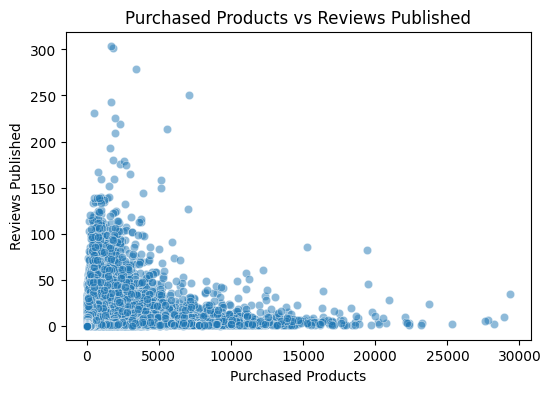

In [123]:
# plot products vs reviews
plt.figure(figsize=(6, 4))
sns.scatterplot(data=users_df, x='products', y='reviews', alpha=0.5)
plt.title('Purchased Products vs Reviews Published')
plt.xlabel('Purchased Products')
plt.ylabel('Reviews Published')
plt.show()

### Reviews

In [28]:
# read in the preprocessed data
reviews_df = pd.read_csv('preprocessed/reviews.csv')
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13207260 entries, 0 to 13207259
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  int64  
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 806.1+ MB


In [29]:
reviews_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,1,36.3,23221,0
1,304390,4,0,2017-02-17,0,11.5,1283,1
2,1085660,2,0,2019-11-17,1,336.5,105979,2
3,703080,0,0,2022-09-23,1,27.4,108133,3
4,526870,0,0,2021-01-10,1,7.9,10612,4


In [30]:
# phrasing the date column
reviews_df['date'] = pd.to_datetime(reviews_df['date'], format='%Y-%m-%d')

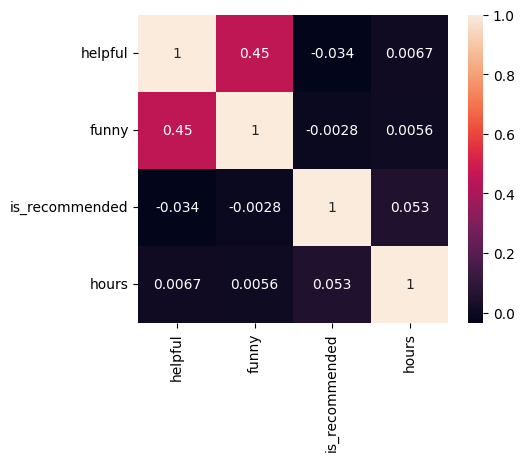

In [31]:
# plot correlation between numerical columns
plt.figure(figsize=(5, 4))
cols = ['helpful', 'funny', 'is_recommended', 'hours']
sns.heatmap(reviews_df[cols].corr(), annot=True)
plt.show()

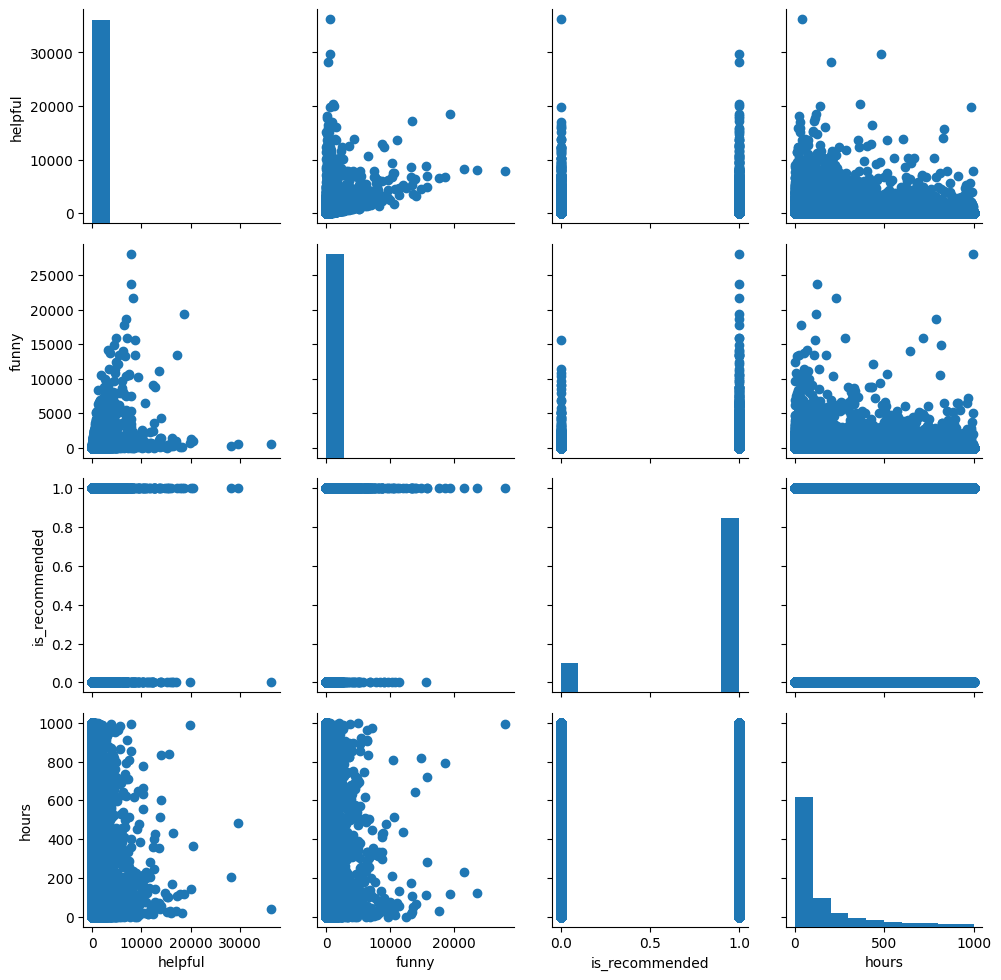

In [32]:
# make pairplot for numerical columns where diagonal is a histogram and other plots are scatter plots

ax = sns.PairGrid(reviews_df[cols], vars=cols)
ax = ax.map_offdiag(plt.scatter)
ax = ax.map_diag(plt.hist)

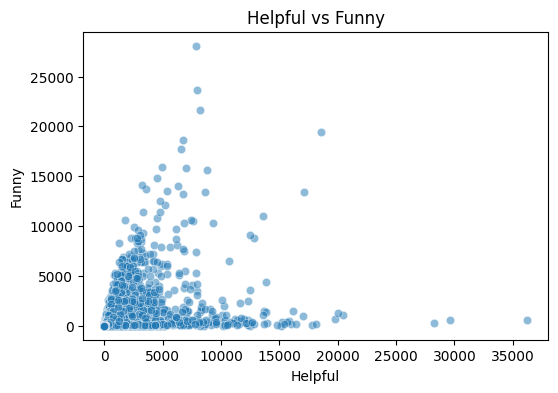

In [124]:
# helpful vs funny
plt.figure(figsize=(6, 4))
sns.scatterplot(data=reviews_df, x='helpful', y='funny', alpha=0.5)
plt.title('Helpful vs Funny')
plt.xlabel('Helpful')
plt.ylabel('Funny')
plt.show()

In [34]:
# helpful value counts
reviews_df['helpful'].value_counts()

helpful
0        10558324
2         1100221
3          448665
4          232067
5          142804
           ...   
2239            1
6826            1
1813            1
2523            1
10547           1
Name: count, Length: 2954, dtype: int64

In [35]:
# funny value counts
reviews_df['funny'].value_counts()

funny
0       12506621
2         279468
3         113013
4          60304
5          36863
          ...   
915            1
1358           1
2106           1
2575           1
2626           1
Name: count, Length: 2168, dtype: int64

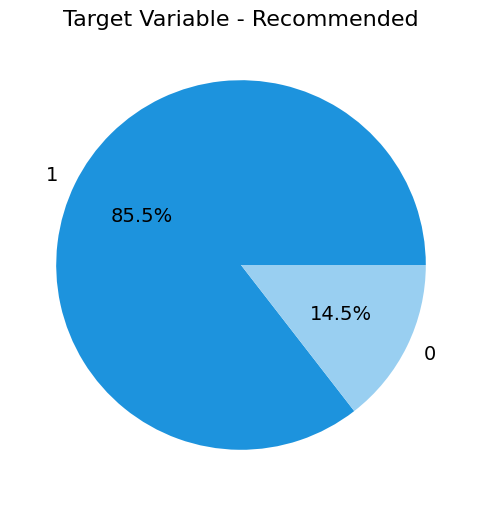

In [128]:
# plot the distribution of is_recommended as pie chart
plt.figure(figsize=(6, 6))
pie = reviews_df['is_recommended'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#1D93DD', '#99cff1'], fontsize=14)
plt.title('Target Variable - Recommended', fontsize=16)
plt.ylabel('')
plt.show()


### User Reviews

In [36]:
# read in preprocessed data
users_reviews_df = pd.read_csv('preprocessed/users_reviews.csv')
users_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13207260 entries, 0 to 13207259
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   products        int64  
 2   reviews         int64  
 3   app_id          int64  
 4   helpful         int64  
 5   funny           int64  
 6   date            object 
 7   is_recommended  int64  
 8   hours           float64
 9   review_id       int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 1007.6+ MB


In [37]:
users_reviews_df.head()

,user_id,products,reviews,app_id,helpful,funny,date,is_recommended,hours,review_id
0,6654146,156,1,730,0,0,2020-09-13,1,515.9,389270
1,4191643,329,4,1259420,5,0,2021-05-18,1,78.9,3220984
2,4191643,329,4,271590,0,0,2022-04-11,1,397.3,3273691
3,4191643,329,4,1029690,0,0,2022-11-26,1,67.6,8177218
4,4191643,329,4,1517290,12,2,2021-11-23,0,1.2,12305209


In [38]:
# phrasing the date column
users_reviews_df['date'] = pd.to_datetime(users_reviews_df['date'], format='%Y-%m-%d')

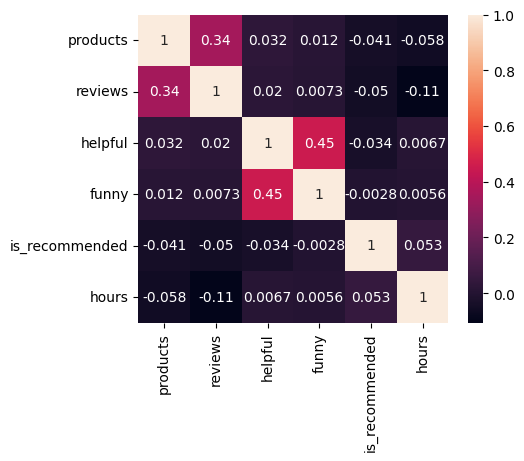

In [39]:
# plot correlation between numerical columns
plt.figure(figsize=(5, 4))
cols = ['products', 'reviews', 'helpful', 'funny', 'is_recommended', 'hours']
sns.heatmap(users_reviews_df[cols].corr(), annot=True)
plt.show()

In [40]:
# group by user_id and count the number of reviews
user_by_app = users_reviews_df.groupby('user_id')['app_id'].count().sort_values(ascending=False)
user_by_app

user_id
5425404    304
180064     302
2028847    279
5568967    250
4234225    243
          ... 
2710902      1
2710901      1
2710900      1
2710899      1
6791174      1
Name: app_id, Length: 6623559, dtype: int64

In [41]:
# group by app_id and count the number of users
app_by_user = users_reviews_df.groupby('app_id')['user_id'].count().sort_values(ascending=False)
app_by_user

app_id
252490     251441
730        172439
275850     150276
431960     149658
271590     148812
            ...  
1454010         2
1870490         1
331181          1
2111850         1
1919140         1
Name: user_id, Length: 1900, dtype: int64

In [42]:
# group by user_id and app_id and count the number of reviews
user_app_by_review = users_reviews_df.groupby(['user_id', 'app_id'])['is_recommended'].count().sort_values(ascending=False)
user_app_by_review

user_id  app_id 
5485922  1142710    2
1978188  451020     2
3999235  270880     2
2474639  266840     2
0        291550     1
                   ..
2482660  381210     1
         386360     1
         387990     1
         389730     1
6791174  397540     1
Name: is_recommended, Length: 13207256, dtype: int64

In [43]:
# drop duplicates from users_reviews_df
users_reviews_df.drop_duplicates(subset=['user_id', 'app_id'], inplace=True)
users_reviews_df.shape

(13207256, 10)

In [44]:
# select only if app_id is in games_detail_df
users_reviews_df = users_reviews_df[users_reviews_df['app_id'].isin(games_detail_df['app_id'])]
users_reviews_df.shape

(13207254, 10)

In [45]:
# subset users_reviews_df to only include users with more than 1% of reviews
users_reviews_sub_df = users_reviews_df[users_reviews_df['user_id'].isin(user_by_app[user_by_app >= 0.01 * len(app_by_user)].index)]
users_reviews_sub_df.shape

(703470, 10)

In [46]:
# save the subset data
users_reviews_sub_df.to_csv('feat/users_reviews_sub.csv', index=False)

In [47]:
user_review_pivot = users_reviews_sub_df.set_index(['user_id', 'app_id'])['is_recommended'].unstack('app_id')
user_review_pivot

app_id   30       60       70       220      400      440      500       
user_id                                                                  
505          NaN      NaN      NaN      1.0      NaN      NaN      NaN  \
1159         NaN      NaN      1.0      NaN      NaN      NaN      NaN   
1292         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1513         NaN      NaN      NaN      NaN      NaN      1.0      NaN   
1526         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...          ...      ...      ...      ...      ...      ...      ...   
6790767      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790874      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790928      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791053      NaN      NaN      NaN      NaN      1.0      NaN      NaN   
6791130      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

app_id   550      570      620      730      1200     1510     1700      
user_id                                                                  
505          NaN      NaN      NaN      NaN      NaN      NaN      NaN  \
1159         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1292         1.0      NaN      1.0      1.0      NaN      NaN      NaN   
1513         1.0      NaN      NaN      NaN      NaN      NaN      NaN   
1526         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...          ...      ...      ...      ...      ...      ...      ...   
6790767      1.0      NaN      NaN      NaN      NaN      NaN      NaN   
6790874      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790928      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791053      NaN      NaN      1.0      NaN      NaN      NaN      NaN   
6791130      1.0      NaN      NaN      1.0      NaN      NaN      NaN   

app_id   3620     3900     4000     4500     4570     4700     4720      
user_id                                                                  
505          NaN      NaN      NaN      NaN      1.0      NaN      NaN  \
1159         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1292         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1513         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1526         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...          ...      ...      ...      ...      ...      ...      ...   
6790767      NaN      NaN      1.0      NaN      NaN      NaN      NaN   
6790874      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790928      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791053      NaN      NaN      NaN      NaN      NaN      NaN      1.0   
6791130      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

app_id   4850     6060     6220     7000     7610     7800     8500      
user_id                                                                  
505          NaN      NaN      NaN      NaN      NaN      NaN      NaN  \
1159         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1292         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1513         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1526         NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...          ...      ...      ...      ...      ...      ...      ...   
6790767      NaN      NaN      NaN      1.0      NaN      NaN      NaN   
6790874      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6790928      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791053      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6791130      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

app_id   8870     8930     8980     9180     9900     10090    10110     
user_id                                                                  


In [48]:
user_review_pivot.shape

(25311, 1867)

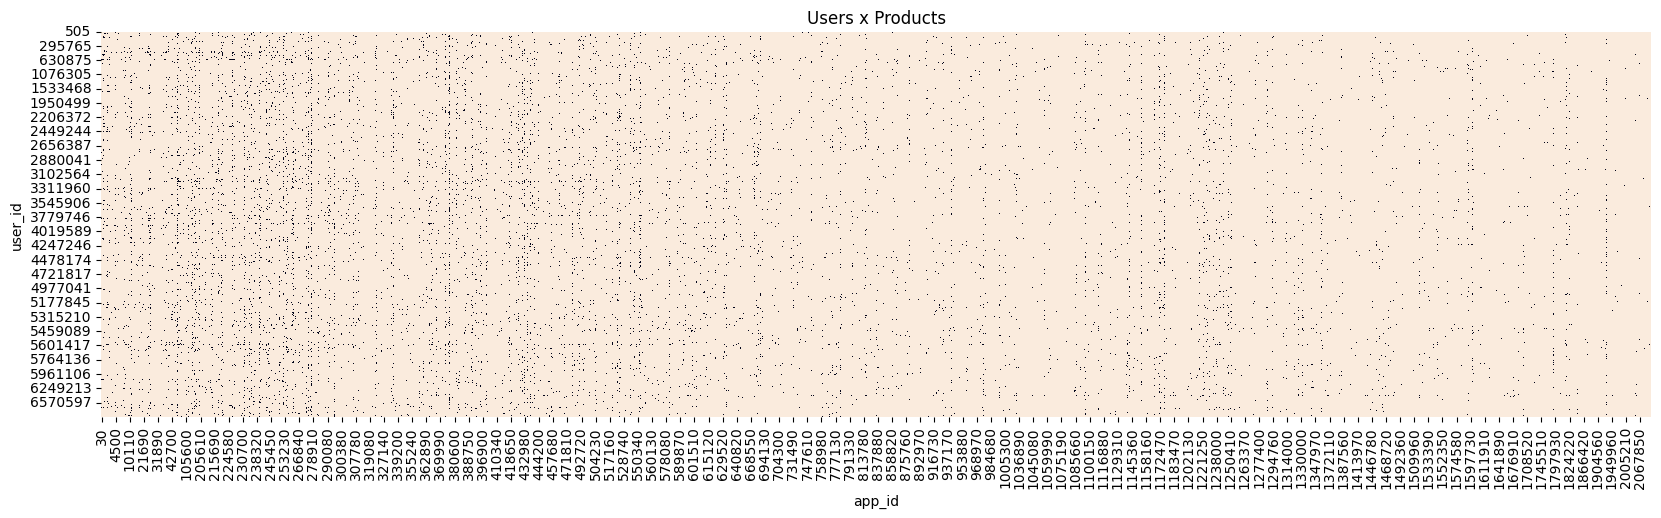

In [49]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(user_review_pivot.isna(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Products")
plt.show()

In [50]:
# save the feature engineered data
user_review_pivot.to_csv('feat/user_review_pivot.csv')